In [100]:
import numpy as np 
from tensorflow.python.framework import ops
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import scipy.io 
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tfdeterminism import patch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report 
patch()

TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [101]:
import numpy as np
from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix

def knn_adjacency_matrix(ALL_X, k=10):
    # Build a KDTree to efficiently compute KNN for each point
    tree = KDTree(ALL_X)

    # Initialize the adjacency matrix with zeros
    N = ALL_X.shape[0]
    A = np.zeros((N, N))

    # Compute the KNN graph for each point
    for i in range(N):
        _, indices = tree.query(ALL_X[i:i+1, :], k+1)
        indices = indices[0, 1:]  # exclude self-connection
        A[i, indices] = 1

    # Convert the graph to a sparse matrix and return it
    ALL_L = csr_matrix(A)
    return ALL_L


In [102]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [103]:
def create_placeholders(n_x, n_y):

    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap = tf.placeholder(tf.float32, [None, None], name = "lap")
    mask_train = tf.placeholder(tf.float32, name = "mask_train")
    mask_test = tf.placeholder(tf.float32, name = "mask_test")
    isTraining = tf.placeholder_with_default(True, shape=())
    
    return x_in, y_in, lap, mask_train, mask_test, isTraining


In [104]:
def initialize_parameters():
   
    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [224,118], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b1 = tf.get_variable("x_b1", [118], initializer = tf.zeros_initializer())
     
    x_w2 = tf.get_variable("x_w2", [118,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b2 = tf.get_variable("x_b2", [12], initializer = tf.zeros_initializer())
    
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters


In [105]:
def GCN_layer(x_in, L_, weights): 
    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

In [106]:
def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.name_scope("x_layer_1"):
        
         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)          
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)   
         x_a1 = tf.nn.relu(x_z1_bn)     

    with tf.name_scope("x_layer_2"):
         
         x_z2_bn = tf.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)            
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         
         
    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss

In [107]:
def mynetwork_optimaization(y_est, y_re, l2_loss, mask, reg, learning_rate, global_step):
    
    with tf.name_scope("cost"):
         cost = (tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss
         mask = tf.cast(mask, dtype = tf.float32)
         mask /= tf.reduce_mean(mask)
         cost *= mask
         cost = tf.reduce_mean(cost) +  reg * l2_loss
         
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer 

In [108]:
def masked_accuracy(preds, labels, mask):

      correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
      accuracy = tf.cast(correct_prediction, "float")
      mask = tf.cast(mask, dtype = tf.float32)
      mask /= tf.reduce_mean(mask)
      accuracy *= mask
      
      return tf.reduce_mean(accuracy)

In [109]:
def train_mynetwork(x_all, y_all, L_all, Cuprite_norm, adj_matrix, mask_in, mask_out, learning_rate = 0.001, beta_reg = 0.001, num_epochs = 200, print_cost = True):
                                    #GCN_mask_TR, GCN_mask_TE
    ops.reset_default_graph()                                                         
    (m, n_x) = x_all.shape             # n_x=200
    (m, n_y) = y_all.shape     
    print(L_all.shape)    # n_y=16  
    # adj_matrix=adj_matrix.todense()

    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap, mask_train, mask_test, isTraining = create_placeholders(n_x, n_y) 
    
    parameters = initialize_parameters()
    with tf.name_scope("network"):
        x_out, l2_loss = mynetwork(x_in, parameters, lap, isTraining)
    global_step = tf.Variable(0, trainable=False)
    
    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, mask_train, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         accuracy_train = masked_accuracy(x_out, y_in, mask_train)
         accuracy_test= masked_accuracy(x_out, y_in, mask_test)
         
    init = tf.global_variables_initializer()
   
    with tf.Session() as sess:
        
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs + 1):

            _, epoch_cost, epoch_acc = sess.run([optimizer, cost, accuracy_train], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: True})
            
            
            features, overall_cost_dev, overall_acc_dev = sess.run([x_out, cost, accuracy_test], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: False})
            # print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, overall_cost_dev, epoch_acc, overall_acc_dev))
            
        
            costs.append(epoch_cost)
            train_acc.append(epoch_acc)
            costs_dev.append(overall_cost_dev)
            val_acc.append(overall_acc_dev)
        print("Training")
        for i in range(5):
            print(f"epoch {i*50}: Train_loss: {costs[i*50]}, Train_acc: {train_acc[i*50]}") 
        print("Validating")
        for j in range(5):
            print(f"epoch {j*50}: Validating_loss: {costs_dev[j*50]}, Validating_acc: {val_acc[j*50]}")
        # Cuprite_out=sess.run([x_out], feed_dict={x_in:Cuprite_norm, lap:adj_matrix, isTraining: False})  
         
        # plot the cost      
        plt.plot(np.squeeze(costs), label='Training cost')
        plt.plot(np.squeeze(costs_dev), label='Validation cost')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc), label='Training accuracy')
        plt.plot(np.squeeze(val_acc), label='Validation accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
    
        return parameters , val_acc, features
     



(314368, 314368)
(1051, 1051)
Training
epoch 0: Train_loss: 23.75800895690918, Train_acc: 0.03804348036646843
epoch 50: Train_loss: 0.762416422367096, Train_acc: 0.7934778332710266
epoch 100: Train_loss: 0.5930484533309937, Train_acc: 0.8355972766876221
epoch 150: Train_loss: 0.5400371551513672, Train_acc: 0.853260338306427
epoch 200: Train_loss: 0.509721040725708, Train_acc: 0.8641298413276672
Validating
epoch 0: Validating_loss: 12.995259284973145, Validating_acc: 0.17777776718139648
epoch 50: Validating_loss: 1.3747488260269165, Validating_acc: 0.4888889789581299
epoch 100: Validating_loss: 0.5990195274353027, Validating_acc: 0.6888890862464905
epoch 150: Validating_loss: 0.5462225675582886, Validating_acc: 0.6825398802757263
epoch 200: Validating_loss: 0.515425443649292, Validating_acc: 0.6857145428657532


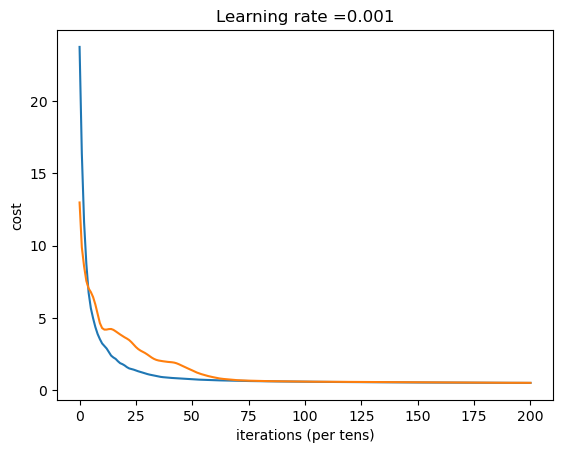

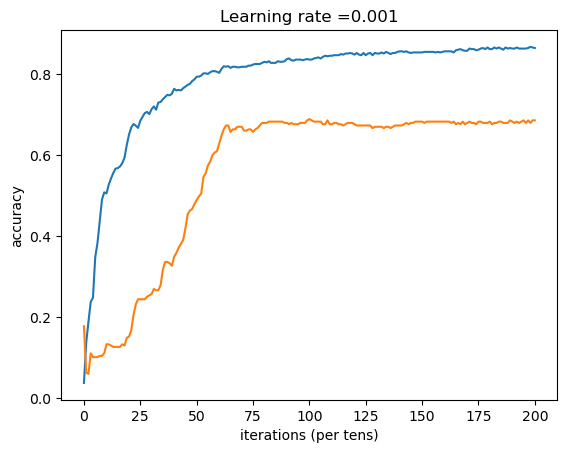

Parameters have been trained!
(1051,) (1051,)
Confusion Matrix:
 [[ 53   0   0   3   0   2   1   0   0   0   0   0]
 [  0  65   5   0   0   0   0  12   4   8   0   0]
 [  0   5  22   0   0   0   2   2   0   0   0   0]
 [  2   0   0  38   0  10   1   0   0   0   0   1]
 [  0   2   0   0 111   0   0   0   2   1   0   0]
 [  1   0   0   6   2  27   0   4  10   0   0   1]
 [  0   0   9   5   0   2  28   6   1   0   0   0]
 [  0   7   6   1   1   0   1  67   6   0   0   1]
 [  0   7   0   1   3   2   0   7 167   0   0   0]
 [  0   2   0   0   0   0   0   0   0 146   9   0]
 [  0   0   0   0   0   0   0   0   0  17 118   0]
 [  0   0   0   7   0   4   6   4   0   0   0   7]]
Accuracy: 0.807802093244529
Precision: 0.7572284342840644
Recall: 0.7297559977865303
F1-score: 0.7314953324121493
ROC AUC score: 0.8410826638422594


In [110]:
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.sparse import csr_matrix

Cuprite_data = scipy.io.loadmat('Cuprite.mat')
Cuprite_data = Cuprite_data['X'] 
CmaxVal = np.amax(Cuprite_data)
CminVal = np.amin(Cuprite_data) 
Cuprite_shifted = Cuprite_data + abs(CminVal) 
Cuprite_norm = Cuprite_shifted / (abs(CminVal) + abs(CmaxVal))
Cuprite_norm = Cuprite_norm + 1e-6 
Cuprite_norm = Cuprite_norm.reshape(-1, Cuprite_norm.shape[-1]) 

Cuprite_graph = scipy.io.loadmat('adj_sparse.mat')
adj_matrix = Cuprite_graph['adj_sparse'] 
print(adj_matrix.shape)

Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
maxVal = np.amax(Labeled_points)
minVal = np.amin(Labeled_points) 
Labeled_points_shifted = Labeled_points + abs(minVal) 
Labeled_points_norm = Labeled_points_shifted / (abs(minVal) + abs(maxVal))
Labeled_points_norm = Labeled_points_norm + 1e-6 

Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12
Labels_onehot = tf.keras.utils.to_categorical(Labels, num_classes) 

GCN_mask_TR = sample_mask(np.arange(0, 736), Labels.shape[0])
GCN_mask_TE = sample_mask(np.arange(736, 1051), Labels.shape[0]) 

temp_L = knn_adjacency_matrix(Labeled_points_norm)
sparse_adj_matrix = csr_matrix(adj_matrix)
  
parameters, val_acc, features = train_mynetwork(Labeled_points_norm, Labels_onehot, temp_L.todense(), Cuprite_norm,sparse_adj_matrix, GCN_mask_TR, GCN_mask_TE)
y_pred = np.argmax(features, axis=1)
y_true = np.argmax(Labels_onehot, axis=1) 

print(y_pred.shape, y_true.shape) 
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", cm)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print("ROC AUC score:", roc_auc_score(Labels_onehot, features, multi_class='ovr'))